# Binary class image classification with perceptron  

In [ ]:
# common imports
import numpy as np
import os
import io
import warnings

# sklearn specific imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint

# To plot pretty figures
import matplotlib.pyplot as plt
import seaborn as sns

## Data loading and splitting  

In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# It returns data and label as pandas dataframe

The data matrix X and the respective label vector y need to be converted to the numpy array by calling a `to_numpy` method.  


In [ ]:
X = X.to_numpy()
y = y.to_numpy()

* Let's get some information like number of features, classes 
* Observe that the labels are of string data type and not integers  

In [ ]:
target_names = np.unique(y)
print(f"Number of samples: {X.shape[0]}, type: {X.dtype}")
print(f"Number of features: {X.shape[1]}")
print(f"Minimum: {np.min(X)}, Maximum: {np.max(X)}")
print(f"Number of classes: {len(target_names)}, type: {y.dtype}")
print(f"Labels: {target_names}")

Number of samples: 70000, type: float64
Number of features: 784
Minimum: 0.0, Maximum: 255.0
Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


## Data scaling  

In [ ]:
X = MinMaxScaler().fit_transform(X)
print(f"Minimum: {np.min(X)}, Maximum: {np.max(X)}")

Minimum: 0.0, Maximum: 1.0


## Data visualization  

Let us pick a few images (the images are already shuffled in the dataset) and display them with their respective labels. As said above, the images are stacked as row vector of size 1 x 784 and therefore must be reshaped to the matrix of size 28 x 28 to display them properly.  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


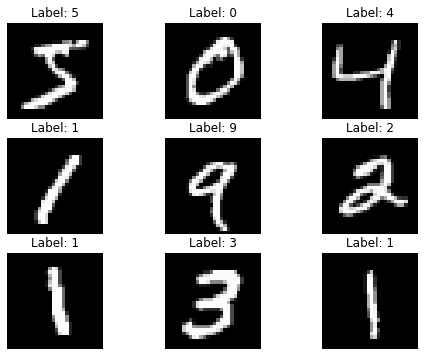

In [ ]:
num_images = 9  # Choose a square number
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0  # take "num_images" starting from the index "idx_offset"
for i in range(factor):
  index = idx_offset + i * (factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28, 28), cmap = 'gray')
    ax[i,j].set_title(f'Label: {str(y[index+j])}')
    ax[i,j].set_axis_off()

## Data splitting  

In [ ]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before we proceed further, we need to check whether the dataset is balanced or imbalanced. We can do it by plotting the distribution of samples in each classes.  

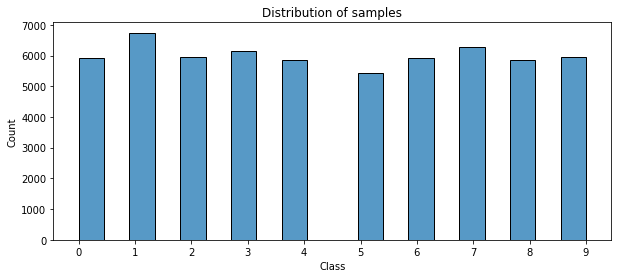

In [ ]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

# Binary Classification: 0-Detector  

## Modifying Labels  
* Let us start with a simple classification problem, that is, binary classification.  
* Since the original label vector contains 10 classes, we need to modify the number of classes to 2  
* Therefore, the label 0 will be changed to 1 and all other (1-9) will be changed to -1  
* We name the label vectors as y_train_0 and y_test_0  

In [ ]:
# Initialize new variable names with all -1
y_train_O = -1 * np.ones((len(y_train)))
y_test_O = -1 * np.ones((len(y_test)))

# Find indices of digit O image
indx_O = np.where(y_train == "0") # Remember original labels are of type str not int
# use those indices to modify y_train_O & y_test_O
y_train_O[indx_O] = 1
indx_O = np.where(y_test == "0")
y_test_O[indx_O] = 1

## Sanity check  

* Complete code could not be seen  
* [Video link](https://youtu.be/i9tCqiNkdLA?t=485)

## Baseline models  

Enough about Data!  
Let us quickly construct a baseline model with the following rule (you are free to choose a different rule)  

1. Count the number of samples per class.  
2. The model always outputs the class which has the highest number of samples.  
3. Then calculate the accuracy of the baseline model.  

In [ ]:
num_pos = len(np.where(y_train_O == 1)[0])
num_neg = len(np.where(y_train_O == -1)[0])
print(num_pos, num_neg)

5923 54077


In [ ]:
base_clf = DummyClassifier(strategy='most_frequent')  # There are other strategies  

In [ ]:
base_clf.fit(x_train, y_train_O)
print(f'Training accuracy: {base_clf.score(x_train, y_train_O):.2f}')
print(f'Testing accuracy: {base_clf.score(x_test, y_test_O):.2f}')

Training accuracy: 0.90
Testing accuracy: 0.90


* Now the reason is obvious. The model would have predicted 54077 sample correctly just by outputting -1 for all the input samples. Therefore the accuracy will be 54077/60000 = 90.12%  
* This is the reason why "accuracy" is not always a good measure.  

# Perceptron model  

Before using perceptron for binary classification, it will be helpful to recall the important concepts (equations) covered in technique course.  
[Video link](https://youtu.be/i9tCqiNkdLA?t=584)

## Instantiation  

In [ ]:
bin_clf = Perceptron(max_iter=100, random_state=1729)

## Training and prediction  

In [ ]:
bin_clf.fit(x_train, y_train_O)
print(f"Dimension of weights w: {bin_clf.coef_.shape}")
print(f"Bias: {bin_clf.intercept_}")
print(f"The loss function: {bin_clf.loss_function_}")

Dimension of weights w: (1, 784)
Bias: [-108.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x7ff053c7bb90>


Let us make predictions on the train set and then calculate the training acccuracy.  

In [ ]:
y_hat_train_O = bin_clf.predict(x_train)
print(f"Training accuracy: {bin_clf.score(x_train, y_train_O)}")

Training accuracy: 0.99095


Let us make predictions on the test set and then calculate the testing accuracy.  

In [ ]:
print(f"Test accuracy: {bin_clf.score(x_test, y_test_O)}")

Test accuracy: 0.989


## Displaying predictions  
* Take few images from the test set at random and display with the corresponding predictons.  
* Plot a few images in a single figure window along with their respective predictons.  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


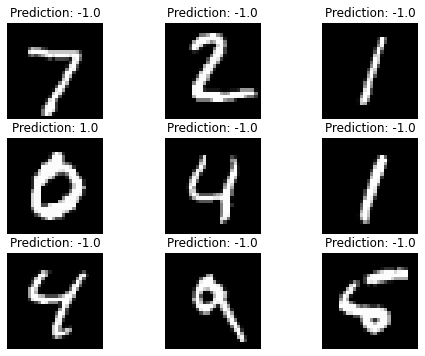

In [ ]:
y_hat_test_O = bin_clf.predict(x_test)
num_images = 9  # choose a square number  
factor = np.int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows=factor, ncols=factor, figsize=(8, 6))
idx_offset = 0    # display 'num_images' starting from idx_offset 
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i, j].imshow(x_test[index+j].reshape(28, 28), cmap="gray") # we should not use x_train_with
    ax[i, j].set_title(f"Prediction: {str(y_hat_test_O[index+j])}")
    ax[i, j].set_axis_off()

* Display images of positive class from testset along with their predictions  

In [ ]:
indx_O = np.where(y_test_O == 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


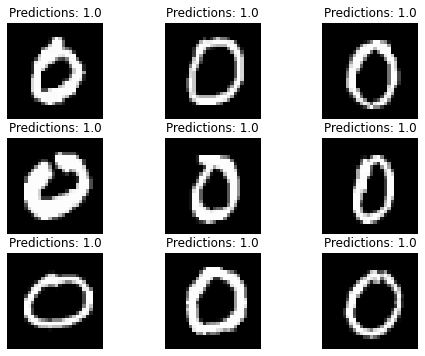

In [ ]:
zeroImgs = x_test[indx_O[0]]
zeroLabls = y_hat_test_O[indx_O[0]]
num_images = 9  # choose a square number  
factor = np.int(np.sqrt(num_images))
fig, ax =plt.subplots(nrows=factor, ncols=factor, figsize=(8,6))
idx_offset = 0  # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset + i*(factor)
  for j in range(factor):
    ax[i, j].imshow(zeroImgs[index+j].reshape(28, 28), cmap="gray") # we should not use x_train_with
    ax[i, j].set_title(f"Predictions: {str(zeroLabls[index+i])}")
    ax[i, j].set_axis_off()

It seems that there are significant number of images that are correctly classified.  
Let's see how many?  

In [ ]:
num_misclassified = np.count_nonzero(zeroLabls==-1)
num_correctpred = len(zeroLabls) - num_misclassified
accuracy = num_correctpred/len(zeroLabls)
print(accuracy)

0.9193877551020408


## Confusion matrix  

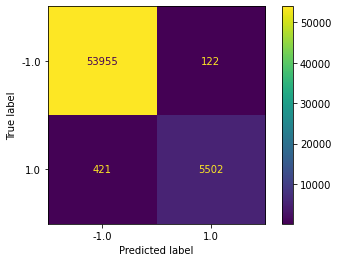

In [ ]:
y_hat_train_O = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_O, y_hat_train_O, values_format=".5g")
plt.show()

* Pay attention to the FPs and FNs 

## Precision and Recall  

* We can use the function `classification_report` to compute these parameters. However, for the time being let's compute these parameters using the data from the confusion matrix manually (not a difficult thing to do, right?)  

In [ ]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [ ]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = (tp+tn) / (tp+tn+fp+fn)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Precision: 0.9783072546230441
Recall: 0.9289211548201924
Accuracy: 0.99095


* The precision is close to 0.98. Despite it, we still want to increase the precision. Let's come back to this later.  
* In general, we would like to know whether the model under consideration with the set hyperparameters is a good one for a given problem.  

## Cross validation  

Perceptron model does not have many hyperparameters.  
We are tuning the learning rate.  

In [ ]:
bin_clf = Perceptron(max_iter=100, random_state=1729) # repeating for readability  
scores = cross_validate(bin_clf, x_train, y_train_O, cv=5,
                        scoring=["precision", "recall", 'f1'],
                        return_estimator=True)
pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([1.1307044 , 2.07902479, 1.44852209, 1.30037546, 1.66533566]),
 'score_time': array([0.04438734, 0.04070306, 0.03989339, 0.04008293, 0.04159737]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


Compute the average and std deviation of scores for all three metrics on (k=5) folds to measure the generalization!  

In [ ]:
print(f"f1,           avg: {scores['test_f1'].mean():.2f}, std: {scores['test_f1'].std():.3f}")
print(f"precision,    avg: {scores['test_precision'].mean():.2f}, std: {scores['test_precision'].std():.3f}")
print(f"recall,       avg: {scores['test_recall'].mean():.2f}, std: {scores['test_recall'].std():.3f}")

f1,           avg: 0.94, std: 0.013
precision,    avg: 0.96, std: 0.013
recall,       avg: 0.92, std: 0.035


* Let us pick the first estimator returned by the cross-validate function.  
* So we can hope the model might also perform well on test data. Let's check that out.  

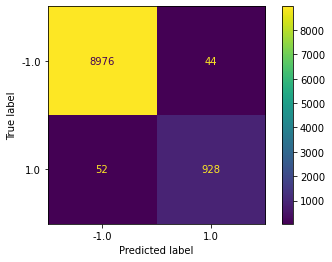

In [ ]:
bin_clf = scores["estimator"][0]
y_hat_test_O = bin_clf.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_O, y_hat_test_O, values_format=".5g")

In [ ]:
print(f"Precision: {precision_score(y_test_O, y_hat_test_O):.2f}")
print(f"Recall: {recall_score(y_test_O, y_hat_test_O):.2f}")

Precision: 0.95
Recall: 0.95


### Way-2 for Generalization:  (optional)  
* There is another approach of getting predicted labels via cross-validation and using it to measure the generalization.  
* In this case, each sample in the dataset will be part of only one test set in the splitted folds.  

In [ ]:
y_hat_train_O = cross_val_predict(bin_clf, x_train, y_train_O, cv=5)

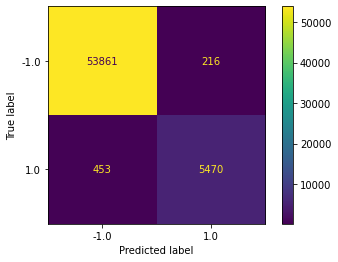

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_O, y_hat_train_O, values_format=".5g")
plt.show()

In [ ]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [ ]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2/((1/precision)+(1/recall))
accuracy = (tp+tn) / (tp+tn+fp+fn)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"f1: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Precision: 0.96
Recall: 0.92
f1: 0.94
Accuracy: 0.99


* Compare the precision and recall score obtained by the above method with that of previous method (i.e, using `cross_validate`)  
* Finally, we can print all these scores as a report using `classification_report` function  

In [ ]:
print(f"Precision: {precision_score(y_train_O, y_hat_train_O):.2f}")
print(f"Recall: {recall_score(y_train_O, y_hat_train_O):.2f}")
print("-"*50)   # Just print dotted line
print(classification_report(y_train_O, y_hat_train_O))

Precision: 0.96
Recall: 0.92
--------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## Precision/Recall tradeoff  

* Often time we need to make a trade off between precision and recall scores of a model.  
* It depends on the problem at hand.  
* It is important to note that we should not pass the predicted labels as input to `precision_recall_curve` function, instead we need to pass the probability scores or the output from the decision function!  
* The `Perceptron()` class contains a `decision_function` method, therefore we can make use of it.  
* Then internally the decision scores are sorted, `tps` and `fps` will be computed by the changing the threshold from index[0] to index[-1 ]  
* Let us compute the scores from the decision function.  

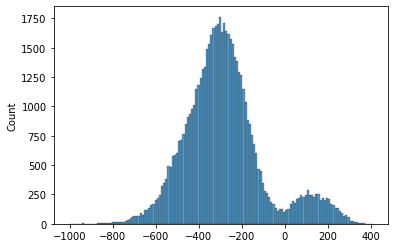

In [ ]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(x_train, y_train_O)
y_scores = bin_clf.decision_function(x_train)
sns.histplot(np.sort(y_scores))
plt.show()

Can you think why there are so many negative values than the positives?  
Hint: Class imbalance  
[Video link](https://youtu.be/i9tCqiNkdLA?t=1318)

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train_O, y_scores, pos_label=1)

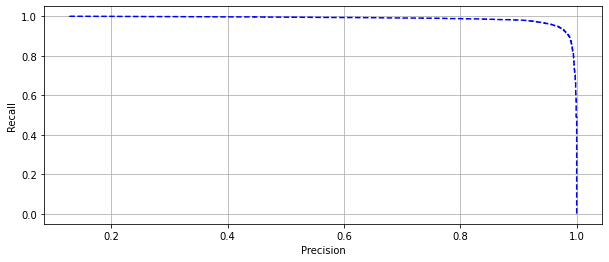

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(precisions[:-1], recalls[:-1], "b--")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.grid(True)
plt.show()

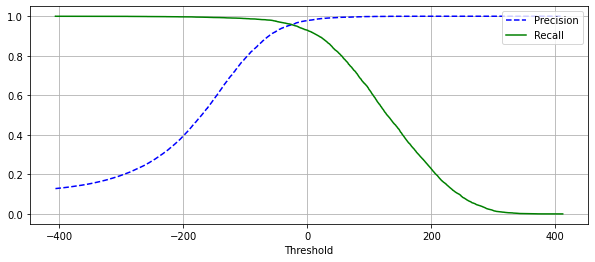

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.grid(True)
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Get the index of threshold around zero
idx_th = np.where(np.logical_and(thresholds>0, thresholds<1))
print(f"Precision for zero threshold: {precisions[idx_th[0][0]]}")

Precision for zero threshold: 0.9783072546230441


Here is the solution to the question how we can increase the precision of the classifier by compromising the recall. We can make use of the above plot.  
Let's see how.  

# The ROC curve  

In [ ]:
from sklearn.metrics import roc_curve

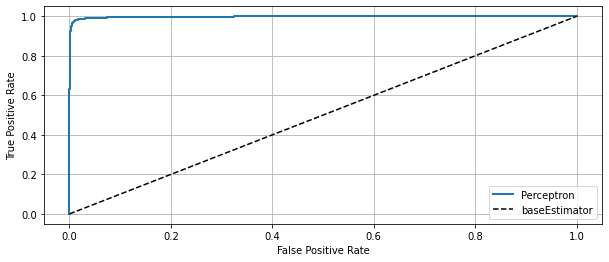

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_O, y_scores)
plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, linewidth=2, label="Perceptron")
plt.plot([0,1], [0,1], "k--", label="baseEstimator")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

# Warm start vs Cold start  

## Cold start  
* If we execute the `fit` method of `bin_clf` repeatedly, we get the same score for both training and testing accuracy.  
* This because everytime the `fit` method is called, the model weights are initialized to the same values. Therefore, we obtain the same score.  
* This is termed as cold start. Let's execute the following cell 4 times and observe the score.  

In [ ]:
bin_clf.fit(x_train, y_train_O)
y_hat_train_O = bin_clf.predict(x_train)
print(f'Training Accuracy: {bin_clf.score(x_train, y_train_O)}')
print(f'Test Accuracy: {bin_clf.score(x_test, y_test_O)}')

Training Accuracy: 0.99095
Test Accuracy: 0.989


## Warm start  

* As you may have guessed, there is an approach `Warm Start`.  
* Setting `warm_start=True` retrains the weight values of the model after `max_iter` and hence produces different results for each execution.  

In [ ]:
bin_clf_warm = Perceptron(max_iter=100, random_state=1729, warm_start=True)

In [ ]:
bin_clf_warm.fit(x_train, y_train_O)
print(f'Training Accuracy: {bin_clf_warm.score(x_train, y_train_O)}')

Training Accuracy: 0.99095
